In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import sqrt, log
import math
from typing import Sequence, Tuple, Dict

# VAE + MNIST

In [ ]:
class ConvVAE(nn.Module):
    """
    Convolutional VAE for square images with pixels in [0,1].
    Uses Bernoulli decoder with BCE-with-logits reconstruction loss.

    - forward(x) returns (x_logits, mu, logvar)
    - reconstruct(x) returns sigmoid(x_logits)
    - sample(n) returns samples in [0,1]
    """

    def __init__(
        self,
        input_size: int,                 # H = W = input_size
        input_channels: int,             # e.g. 1 (MNIST) or 3 (RGB)
        hidden_channels: Sequence[int],  # e.g. (32, 64, 128)
        latent_dim: int,
        act: str = "relu",               # "relu" or "silu" or "lrelu"
    ):
        super().__init__()
        # NOTE: no power-of-two constraint. Any positive size works.
        if input_size <= 0:
            raise ValueError("input_size must be positive.")

        if len(hidden_channels) < 1:
            raise ValueError("hidden_channels must have at least one element.")

        self.input_size = input_size
        self.input_channels = input_channels
        self.hidden_channels = list(hidden_channels)
        self.latent_dim = latent_dim

        # --- Activation ---
        if act == "relu":
            Act = lambda: nn.ReLU(inplace=True)
        elif act == "silu":
            Act = lambda: nn.SiLU(inplace=True)
        elif act == "lrelu":
            Act = lambda: nn.LeakyReLU(0.2, inplace=True)
        else:
            raise ValueError(f"Unknown act='{act}'")

        # --- Encoder conv stack ---
        enc_layers = []
        in_ch = input_channels
        for out_ch in self.hidden_channels:
            enc_layers += [
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1),
                Act(),
            ]
            in_ch = out_ch
        self.encoder = nn.Sequential(*enc_layers)

        # Determine encoder output shape dynamically (robust)
        with torch.no_grad():
            dummy = torch.zeros(1, input_channels, input_size, input_size)
            h = self.encoder(dummy)
            self._enc_shape = tuple(h.shape[1:])  # (C', H', W')
            self._enc_flat_dim = h.flatten(1).shape[1]

        # Latent heads
        self.fc_mu = nn.Linear(self._enc_flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self._enc_flat_dim, latent_dim)

        # --- Decoder head: latent -> conv feature map ---
        self.fc_dec = nn.Linear(latent_dim, self._enc_flat_dim)

        # --- Decoder conv-transpose stack ---
        # mirror hidden_channels in reverse
        dec_layers = []
        rev = list(reversed(self.hidden_channels))
        for i, in_ch in enumerate(rev):
            out_ch = input_channels if i == (len(rev) - 1) else rev[i + 1]
            dec_layers.append(
                nn.ConvTranspose2d(
                    in_ch, out_ch,
                    kernel_size=3, stride=2, padding=1, output_padding=1
                )
            )
            # no activation on last layer: output are logits
            if i != (len(rev) - 1):
                dec_layers.append(Act())
        self.decoder = nn.Sequential(*dec_layers)

        # Optional: warn if shape mismatch happens (odd sizes + many downsamples can do this)
        with torch.no_grad():
            z0 = torch.zeros(1, latent_dim)
            x_logits0 = self.decode_logits(z0)
            if x_logits0.shape[-2:] != (input_size, input_size):
                # Don't hard-fail; just make it obvious early.
                raise ValueError(
                    f"Decoder output spatial size {tuple(x_logits0.shape[-2:])} "
                    f"does not match input_size {(input_size, input_size)}. "
                    f"Fix by adjusting num layers/strides or decoder output_padding."
                )

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.encoder(x).flatten(1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    @staticmethod
    def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_logits(self, z: torch.Tensor) -> torch.Tensor:
        h = self.fc_dec(z).view(z.size(0), *self._enc_shape)
        x_logits = self.decoder(h)
        return x_logits

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_logits = self.decode_logits(z)
        return x_logits, mu, logvar

    @torch.no_grad()
    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        x_logits, _, _ = self.forward(x)
        return torch.sigmoid(x_logits)

    @torch.no_grad()
    def sample(self, n: int, device: torch.device | None = None) -> torch.Tensor:
        if device is None:
            device = next(self.parameters()).device
        z = torch.randn(n, self.latent_dim, device=device)
        x_logits = self.decode_logits(z)
        return torch.sigmoid(x_logits)

def vae_loss_bce_logits(
    x: torch.Tensor,
    x_logits: torch.Tensor,
    mu: torch.Tensor,
    logvar: torch.Tensor,
    beta: float = 1.0,
    reduction: str = "sum",
) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    ELBO = recon + beta * KL
    recon: Bernoulli likelihood => BCE-with-logits
    KL: q(z|x) || N(0,I)
    """
    if reduction not in ("sum", "mean"):
        raise ValueError("reduction must be 'sum' or 'mean'")

    recon = F.binary_cross_entropy_with_logits(x_logits, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = recon + beta * kl

    if reduction == "mean":
        loss = loss / x.size(0)
        recon = recon / x.size(0)
        kl = kl / x.size(0)

    stats = {"loss": loss.detach(), "recon": recon.detach(), "kl": kl.detach()}
    return loss, stats


In [ ]:
def train_one_epoch(
    model: nn.Module,
    dataloader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    beta: float = 1.0,
    reduction: str = "mean",
) -> Dict[str, float]:
    model.train()
    totals = {"loss": 0.0, "recon": 0.0, "kl": 0.0}
    n_batches = 0

    for x, *_ in dataloader:
        x = x.to(device)

        optimizer.zero_grad(set_to_none=True)
        x_logits, mu, logvar = model(x)
        loss, stats = vae_loss_bce_logits(x, x_logits, mu, logvar, beta=beta, reduction=reduction)
        loss.backward()
        optimizer.step()

        for k in totals:
            totals[k] += float(stats[k])
        n_batches += 1

    for k in totals:
        totals[k] /= max(1, n_batches)
    return totals


In [ ]:
input_size = 28
input_channels = 1
hidden_channels = (32, 64)
latent_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps"
model = ConvVAE(
    input_size=input_size,
    input_channels=input_channels,
    hidden_channels=hidden_channels,
    latent_dim=latent_dim,
    act="relu",
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ← convert RGB → grayscale
    transforms.ToTensor(),                         # shape: (1, 32, 32)
])
dataset = torchvision.datasets.CIFAR10(root="./sample_data", train=True, download=False, transform=transform)
dataset = torchvision.datasets.MNIST(root="./sample_data", train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./sample_data", train=False, download=False, transform=transform)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    stats = train_one_epoch(model, dataloader, optimizer, device, beta=1.0, reduction="mean")
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {stats['loss']:.4f}, Recon: {stats['recon']:.4f}, KL: {stats['kl']:.4f}")

In [389]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)
x, y = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    recon = model.reconstruct(x.to(device)).to("cpu")
    mean, logvariance  = model.encode(x.to(device))
    mean = mean.to("cpu")
    logvariance = logvariance.to("cpu")

In [ ]:
patterns = mean + torch.randn_like(logvariance)*torch.exp(0.5 * logvariance) 

## Direct Optimization

In [415]:
betas = torch.linspace(0, 10, 1000)
recovered_patterns = torch.randn((betas.size(0), patterns.size(1)))
dt = 0.9
for step in range(300):
    w = torch.softmax(torch.sum(betas[:,None,None]*patterns[None,:,:]*recovered_patterns[:,None,:], dim=-1), dim=-1)
    recovered_patterns += dt * (torch.einsum('bk,ki->bi', w, patterns) - recovered_patterns)
with torch.no_grad():
    recon_patterns = torch.sigmoid(model.decode_logits(recovered_patterns.to(device))).cpu()

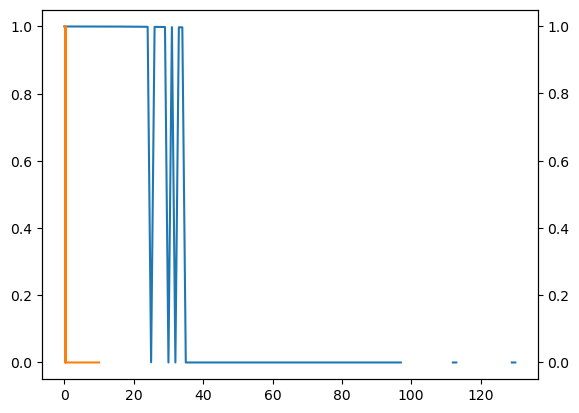

In [416]:
plt.plot( -(torch.log(w)*w).sum(dim=1)/log(patterns.size(0)))
plt.gca().twinx().plot(betas, 1-(w**4).sum(dim=1)/(w**2).sum(dim=1)**2, color='tab:orange')

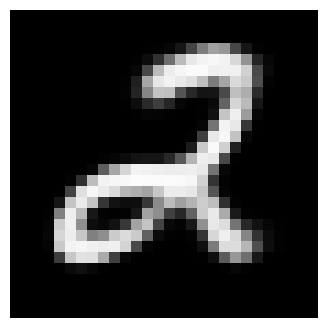

In [417]:
fig, axes = plt.subplots(figsize=(4, 4))
ims = []
for i in range(betas.size(0)):
    im = axes.imshow(
        recon_patterns[i, 0],
        vmin=0,
        vmax=1,
        cmap="gray",
        animated=True
    )
    ims.append([im])
axes.axis("off")
ani = animation.ArtistAnimation(
    fig,
    ims,
    interval=50,   # ms between frames
    blit=True)
ani.save("recon_animation.mp4", fps=24)

In [418]:
class_weight = torch.zeros((betas.size(0), 10), device=w.device, dtype=w.dtype)

class_weight = class_weight.scatter_add_(
    dim=1,
    index=y.unsqueeze(0).expand(betas.size(0), patterns.size(0)),
    src=w
)

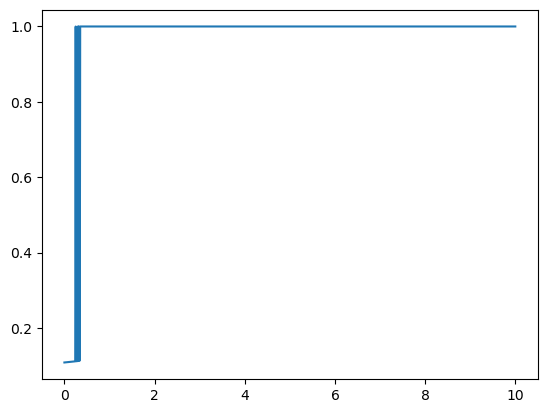

In [419]:
plt.plot(betas.cpu(), class_weight.max(dim=1).values.cpu())

## Dual

In [373]:
gram_matrix =  torch.einsum('ki,li->kl', patterns.view(patterns.size(0), -1), patterns.view(patterns.size(0), -1))
diag = torch.diagonal(gram_matrix)
C = gram_matrix / torch.sqrt(torch.outer(diag, diag))

In [382]:
# dual approach
betas = torch.linspace(0, 100, 1000)
K = C.size(0)
w = torch.distributions.dirichlet.Dirichlet(torch.ones(K)).sample((betas.size(0),))
eta = 0.1
# w = softmax(beta*C @ w)
for step in range(1000):
    current = torch.softmax(betas[:,None] * w @ C, dim=1)
    w = eta*w + (1-eta)*current
    if step % 1000 == 0:
        print(f"Step {step}")
    #w += dt*(w @ C - (torch.log(w)+1)/betas[:, None])
    #w /= w.sum(dim=1, keepdim=True)

recovered_patterns = torch.sum(w[:, :, None]*patterns[None, :, :], dim=1)
with torch.no_grad():
    recon_patterns = torch.sigmoid(model.decode_logits(recovered_patterns.to(device))).cpu()

Step 0


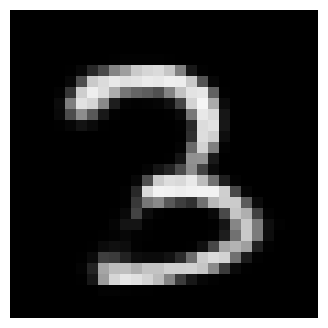

In [383]:
fig, axes = plt.subplots(figsize=(4, 4))
ims = []
for i in range(betas.size(0)):
    im = axes.imshow(
        recon_patterns[i, 0],
        vmin=0,
        vmax=1,
        cmap="gray",
        animated=True
    )
    ims.append([im])
axes.axis("off")
ani = animation.ArtistAnimation(
    fig,
    ims,
    interval=50,   # ms between frames
    blit=True)
ani.save("recon_animation.mp4", fps=24)

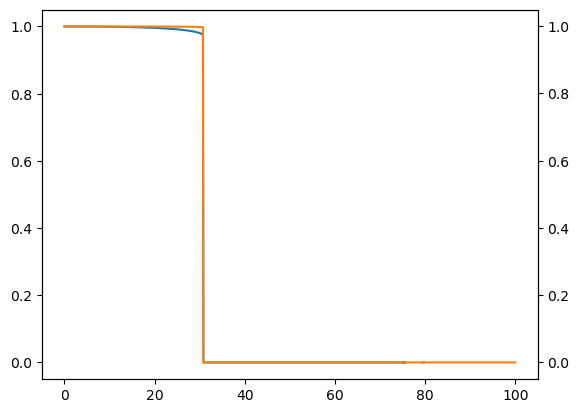

In [384]:
plt.plot(betas, -(torch.log(w)*w).sum(dim=1)/log(K))
plt.gca().twinx().plot(betas, 1-(w**4).sum(dim=1)/(w**2).sum(dim=1)**2, color='tab:orange')

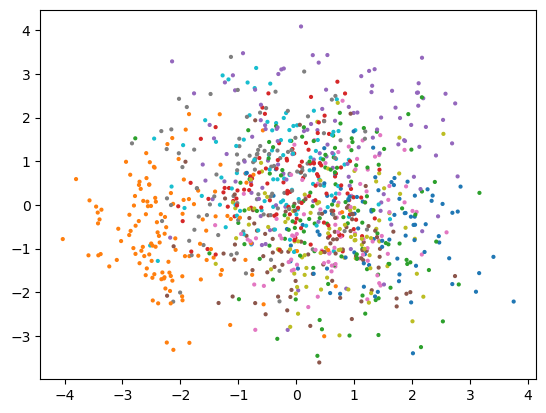

In [385]:
from sklearn.decomposition import PCA
patterns_pca = PCA(n_components=2).fit_transform(patterns.view(patterns.size(0), -1))
plt.scatter(patterns_pca[:, 0], patterns_pca[:, 1], c=y, cmap="tab10", s=4)

In [386]:
class_weight = torch.zeros((betas.size(0), 10), device=w.device, dtype=w.dtype)

class_weight = class_weight.scatter_add_(
    dim=1,
    index=y.unsqueeze(0).expand(betas.size(0), K),
    src=w
)

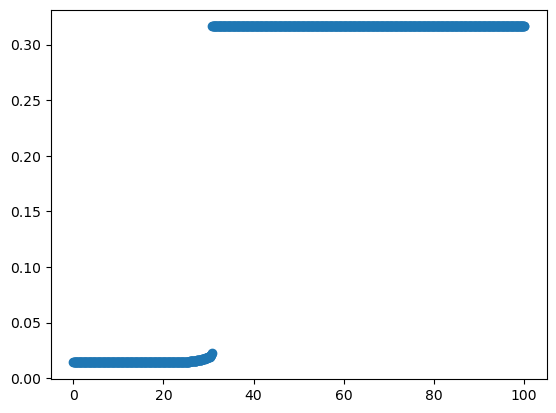

In [388]:
plt.scatter(betas.cpu(), class_weight.cpu().std(dim=1))

### Analytical models

In [ ]:
K = 1024
B = K // 32
rho1 = 1.0/(B-1)
rho0 = 0.99/(K-1)
m_a = torch.arange(1,1+B).float()
m_b = torch.arange(1, 1 + K//B).float()


In [ ]:
%matplotlib inline
for beta in torch.logspace(0, 5, 25):
    F = (1-rho0)/(2*m_a[:,None]*m_b[None,:]) + torch.log(m_a[:,None]*m_b[None,:])/(beta) + (rho0-rho1)/(2*m_b)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(*torch.meshgrid(m_a, m_b), F, facecolors=plt.cm.viridis((F - F.min()) / (F.max() - F.min())), rstride=1, cstride=1, antialiased=False)
    ax.set_xlabel("m_a")
    ax.set_ylabel("m_b")
    ax.set_title( f"Beta: {beta:.2e} " + str(1+torch.tensor(torch.unravel_index(torch.argmax(F), F.shape))))
    plt.show()

In [ ]:
K = 1024
B = K // 32
N = 16
rho1 = 0.1
rho0 = -0.5/(K-1)
C = rho0*torch.ones((K,K))
for g in range(0,K, B):
    C[g:g+B, g:g+B] = rho1  
#rho = 0.1/(K-1)
#C = rho*torch.ones((K,K))
_ = torch.diagonal(C).fill_(1.0)
L = torch.linalg.cholesky(C) 
P = (torch.randn((N,K)) @ L.T).T

In [ ]:
#m = torch.arange(1, 1+K).float()
#F = (1-rho)/(2*m[None,:]) + torch.log(m[None,:])/(betas[:,None])
#plt.contourf(torch.log(F), levels=20)
#plt.colorbar()

In [ ]:
# dual approach
betas = torch.logspace(-5, 5, 200)
w = torch.distributions.dirichlet.Dirichlet(torch.ones(K)).sample((betas.size(0),))
eta = 0.9
# w = softmax(beta*C @ w)
for step in range(5000):
    current = torch.softmax(betas[:,None] * w @ C, dim=1)
    w = eta*w + (1-eta)*current
    #w += dt*(w @ C - (torch.log(w)+1)/betas[:, None])
    #w /= w.sum(dim=1, keepdim=True)

In [ ]:
plt.scatter(betas, - (torch.log(w)*w).sum(dim=1)/log(K))
#plt.gca().twinx().plot(betas,torch.clip(betas*(1-rho)/2, 1, K).int()/K)
plt.xscale('log')
plt.xlabel('$\\beta$')
plt.ylabel("Entropy")
plt.show()

In [ ]:
betas = torch.linspace(0.5, 1.0, 200)
x = torch.randn((betas.size(0), N))
dt =0.01
for step in range(100000):
    y = (betas[:, None, None] * P[None, :, :] * x[:, None, :]).sum(dim=2)
    w = torch.softmax(y, dim=-1)
    x += dt*((P[None, :, :]*w[:, :, None]).sum(dim=1) - x)

In [ ]:
plt.scatter(betas, -torch.sum(w*torch.log(w), dim=1) / torch.log(torch.tensor(K)))

In [ ]:
plt.scatter(betas, torch.sum(w**4, dim=1)/torch.sum(w**2, dim=1)**2, marker='o')
plt.show()